# Introduction

This notebook demonstrates simble **Data Augumentation** combined with **ConvNet** and applied to [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

**Contents**

* [CIFAR-10 Dataset](#CIFAR-10-Dataset) - load and preprocess dataset
* [Data Aug. Setup](#Data-Aug.-Setup) - setup data augumentation
* [Data Aug. Model](#Data-Aug.-Model) - make and train model
* [Baseline Model](#Baseline-Model) - w/o data aug for comparison

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage


In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

# CIFAR-10 Dataset

Load dataset and show example images

In [3]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()
class2txt = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Show example images

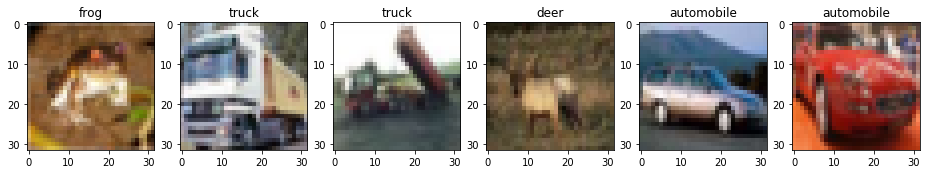

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(class2txt[y_train_raw[i, 0]])
    axes[i].imshow(x_train_raw[i])

Normalize features

In [5]:
x_train = (x_train_raw - x_train_raw.mean()) / x_train_raw.std()
x_test = (x_test_raw - x_train_raw.mean()) / x_train_raw.std()
print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

x_train.shape (50000, 32, 32, 3)
x_test.shape (10000, 32, 32, 3)


One-hot encode labels

In [6]:
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=10)
print('y_train.shape', y_train.shape)
print(y_train[:3])

y_train.shape (50000, 10)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Data Aug. Setup

Setup Keras image data augumentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator(
    rotation_range=10,       # random rotation degrees
    width_shift_range=0.1,   # random shift 10%
    height_shift_range=0.1,
    horizontal_flip=True)

Show a horse

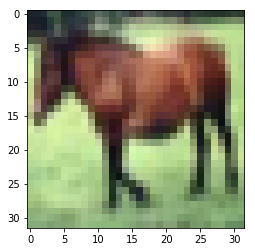

In [8]:
plt.imshow(x_train_raw[7]);

Show more horses

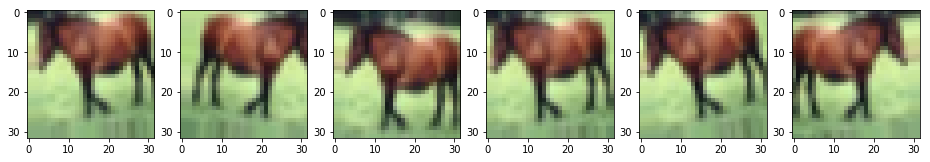

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i, x_horse in enumerate(img_data_gen.flow(x_train_raw[7:8], batch_size=1)):
    axes[i].imshow(x_horse.astype(int)[0])
    if i >= len(axes)-1:
        break

**Note:** Keras ImageDataGenerator seems to run on *single CPU thread*, which makes it very slow. On my PC single epoch approx 20s

In [10]:
import time

ts = time.time()
for i, (x_batch, y_batch) in enumerate(img_data_gen.flow(x_train, y_train, batch_size=250)):
    if i >= 250:
        break
print(time.time() - ts)

21.449058055877686


# Data Aug. Model

Simple ConvNet, no changes here

In [11]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization

model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(512, activation='elu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
__________

Train model with data augumentation (this will take a while)

In [12]:
hist = model.fit_generator(generator=img_data_gen.flow(x_train, y_train, batch_size=250),
                           steps_per_epoch=len(x_train)/250, epochs=10, verbose=2)

Epoch 1/10
 - 19s - loss: 1.5064 - acc: 0.4615
Epoch 2/10
 - 18s - loss: 1.2440 - acc: 0.5624
Epoch 3/10
 - 18s - loss: 1.1553 - acc: 0.5969
Epoch 4/10
 - 18s - loss: 1.0965 - acc: 0.6153
Epoch 5/10
 - 18s - loss: 1.0506 - acc: 0.6299
Epoch 6/10
 - 18s - loss: 1.0136 - acc: 0.6448
Epoch 7/10
 - 18s - loss: 0.9788 - acc: 0.6538
Epoch 8/10
 - 18s - loss: 0.9448 - acc: 0.6679
Epoch 9/10
 - 18s - loss: 0.9156 - acc: 0.6775
Epoch 10/10
 - 18s - loss: 0.8866 - acc: 0.6890


In [13]:
loss, acc = model.evaluate(x_train, y_train, batch_size=250, verbose=0)
print(f'Accuracy on train set: {acc:.3f}')
loss, acc = model.evaluate(x_test, y_test, batch_size=250, verbose=0)
print(f'Accuracy on test set:  {acc:.3f}')

Accuracy on train set: 0.739
Accuracy on test set:  0.723


Note only .014 difference between train/test accuracy

# Baseline Model

Simple ConvNet

In [15]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization

model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(512, activation='elu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

Train model

In [16]:
hist = model.fit(x=x_train, y=y_train, batch_size=250, epochs=10,
                 validation_data=(x_test, y_test), verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 1.4000 - acc: 0.5077 - val_loss: 1.1499 - val_acc: 0.6005
Epoch 2/10
 - 3s - loss: 1.1007 - acc: 0.6148 - val_loss: 1.0325 - val_acc: 0.6402
Epoch 3/10
 - 3s - loss: 0.9963 - acc: 0.6512 - val_loss: 0.9652 - val_acc: 0.6672
Epoch 4/10
 - 3s - loss: 0.9230 - acc: 0.6767 - val_loss: 0.9161 - val_acc: 0.6807
Epoch 5/10
 - 3s - loss: 0.8656 - acc: 0.6980 - val_loss: 0.8870 - val_acc: 0.6925
Epoch 6/10
 - 3s - loss: 0.8214 - acc: 0.7113 - val_loss: 0.8390 - val_acc: 0.7100
Epoch 7/10
 - 3s - loss: 0.7755 - acc: 0.7281 - val_loss: 0.8223 - val_acc: 0.7142
Epoch 8/10
 - 3s - loss: 0.7367 - acc: 0.7404 - val_loss: 0.7749 - val_acc: 0.7284
Epoch 9/10
 - 3s - loss: 0.6893 - acc: 0.7594 - val_loss: 0.7660 - val_acc: 0.7352
Epoch 10/10
 - 3s - loss: 0.6523 - acc: 0.7702 - val_loss: 0.7610 - val_acc: 0.7413


Final results

In [17]:
loss, acc = model.evaluate(x_train, y_train, batch_size=250, verbose=0)
print(f'Accuracy on train set: {acc:.3f}')
loss, acc = model.evaluate(x_test, y_test, batch_size=250, verbose=0)
print(f'Accuracy on test set:  {acc:.3f}')

Accuracy on train set: 0.823
Accuracy on test set:  0.741


Much higher difference between train/test accuracy. Data augumetion clearly helps as regularizer.

Over model test accuracy is better here, but neither model converged.